# Notebook on how to check your fMRI data

Authors: Eduarda Centeno
    
The goal is to show how to work with matrices, how to plot and what to check.


#### Let's start with the necessary packages for the following computations:

    Requirements: 
    
    - Python: 3.7.3
    - Numpy: 1.16.3
    - Matplotlib: 3.2.1
    - Seaborn: 0.10.1
    - Pandas: 1.0.3
    - JupyterLab: 1.2.0
    
    
    


In [1]:
## Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob

### Some key tips:

    - You should check if there are NaNs, zeros, infs in the matrix. This can indicate some lack of signal in one of the regions (e.g. common in orbitofrontal regions). If that's the case, take notes of the regions you found NaNs, zeros or infs and discuss with your supervisor.
    - If using AAL -- work only with the 78 first regions.
    - If using BNA -- work only with the 210 first regions.
    - We usually remove regions that have less than 5 voxels of signal (e.g. orbitofrontal regions)
    - If working with matrices of the same size (might differ if removing regions because of a tumor, for example), one can average them out and plot:
        - Correlation strength distribution
        - Check correlations for the Default Mode Network. The idea is that we expect the connectivity within the DMN to be stronger than outside it. This will be done in several steps over the notebook. First, identifying this DMN region names an highlighting them, then preparing the matrix for normalized evaluation, and then finishing with a quick numerical comparsion (last cell).
    - Connectivity matrix should show 3 diagonals. Usually, there are clusters around the central diagonal that indicate modularity, whereas the 2 other diagonals indicate inter-hemispheric connections
    - Lower connectivity values can indicate a lower signal originally.
    - We also work with normalized matrices for final analysis (Absolutize > Z-score > Rescale)
    - Taking into account the more granular parcelation, it is expected that BNA matrices will have lower connectivity values compared to AAL matrices.

In [2]:
# Choose which atlas to work with
atlas = 'BNA' # or AAL
size = 10
linewidth = 0
figsize = (40,35)
sns.set_context('notebook', font_scale=1.5)
    
# Define pallete that will be used
pallete = 'coolwarm' # sns.color_palette('coolwarm') # option 3: 'colorblind'

if atlas == 'BNA': # if working with BNA, check section 'Important step for BNA matrices'
    matrixfile = 'BNA_matrix.txt'
    areasfile = './bna_areas.txt'
    subnetfile = './yeo_7networks_bna_order.txt'
    prec_L_area = 'Left_A31' # to be used with BNA
    prec_R_area = 'Right_A31' # to be used with BNA
    
elif atlas == 'AAL':
    matrixfile = 'AAL_matrix.txt'
    areasfile = './aal_areas.txt'
    subnetfile = './yeo_7networks_aal_order.txt'
    prec_L_area = 'PrecL' # to be used with AAL
    prec_R_area = 'PrecR' # to be used with AAL

In [3]:
# Import the example matrix
matDF = pd.read_csv(matrixfile, delim_whitespace=True, header=None)

# Import a list of region names
names = [line.rstrip('\n') for line in open(areasfile)]
DFnames = pd.DataFrame(names)

# Subnetwork information
regs = np.loadtxt(subnetfile, dtype=int)

#################################################################################################################
### Important step for BNA matrices.
Due to our preprocessing pipeline, we need to first reorder matrices (Left-Right reordering)

In [4]:
# Define function to re-order regions of the BNA 

def reorder(adjmat, neworder_filepath='./bna_subnetorder.txt', subcortical=False):
    """" Reorder a connectivity matrix according to a specific ordering (e.g. BNA in order 
    of subnetwork, with all left hemisphere regions first and then all right hemisphere regions)
    
    Parameters
    ----------
    adjmat: dataframe or ndarray
        Dataframe or ndarray to be reordered
    neworder_filepath: string
        Path to tab-delimited .txt file containing desired order of regions
    subcortical: boolean, optional
        Specify whether there are subcortical regions in adjmat, default=False
        
    Returns
    -------
    adjmat_reorder: dataframe
        Reordered dataframe
        
    """
    if type(adjmat)==np.ndarray:
        adjmat = pd.DataFrame(adjmat)
    
    neworder = pd.read_csv(neworder_filepath, delimiter='\t')
    
    if subcortical == False:
        neworder.drop(neworder[neworder['Yeo Labels']=='subcortical'].index, inplace=True)

    roiorder = neworder['BNA region']
    roiorder = list(map(lambda x: x.replace('BNA ', ''), roiorder))
    roiorder_int = list(map(int, roiorder))
    roiorder_id = [x - 1 for x in roiorder_int]
    
    adjmat_reorder = adjmat[roiorder_id]
    adjmat_reorder = adjmat_reorder.loc[roiorder_id]
    
    return adjmat_reorder, roiorder_id

In [5]:
# Reoder BNA matrix
if atlas == 'BNA':
    matDF, roiorder_id = reorder(matDF)
    matDF.index = range(len(matDF))
    matDF.columns = range(len(matDF)) # this is the same as BNA_reordered.txt

#################################################################################################################

In [6]:
# Checking if there are NaNs, infs, zeros.
print('Matrix has Infs: ' + str(np.isinf(matDF.values).any()))
print('Matrix has NaNs: ' + str(np.isnan(matDF.values).any()))
print('Matrix has Zeros: ' + str((matDF.values==0).any()))

Matrix has Infs: False
Matrix has NaNs: True
Matrix has Zeros: False


In [7]:
# Finding where the NaNs, infs, zeros, are (result in indexes, not regions' numbers)
print('NaNs can be found at: \n' + str(np.argwhere(np.isnan(matDF.values))))
print('\n Infs can be found at: \n' + str(np.argwhere(np.isinf(matDF.values))))
print('\n Zeros can be found at: \n' + str(np.argwhere(matDF.values==0)))

NaNs can be found at: 
[[  0  23]
 [  0 128]
 [  0 163]
 ...
 [209  23]
 [209 128]
 [209 163]]

 Infs can be found at: 
[]

 Zeros can be found at: 
[]


##### As it is possible to see, the matrix has NaNs, this will be evident by plotting a heatmap / connectivity matrix below as blank lines:

(210.0, 0.0)

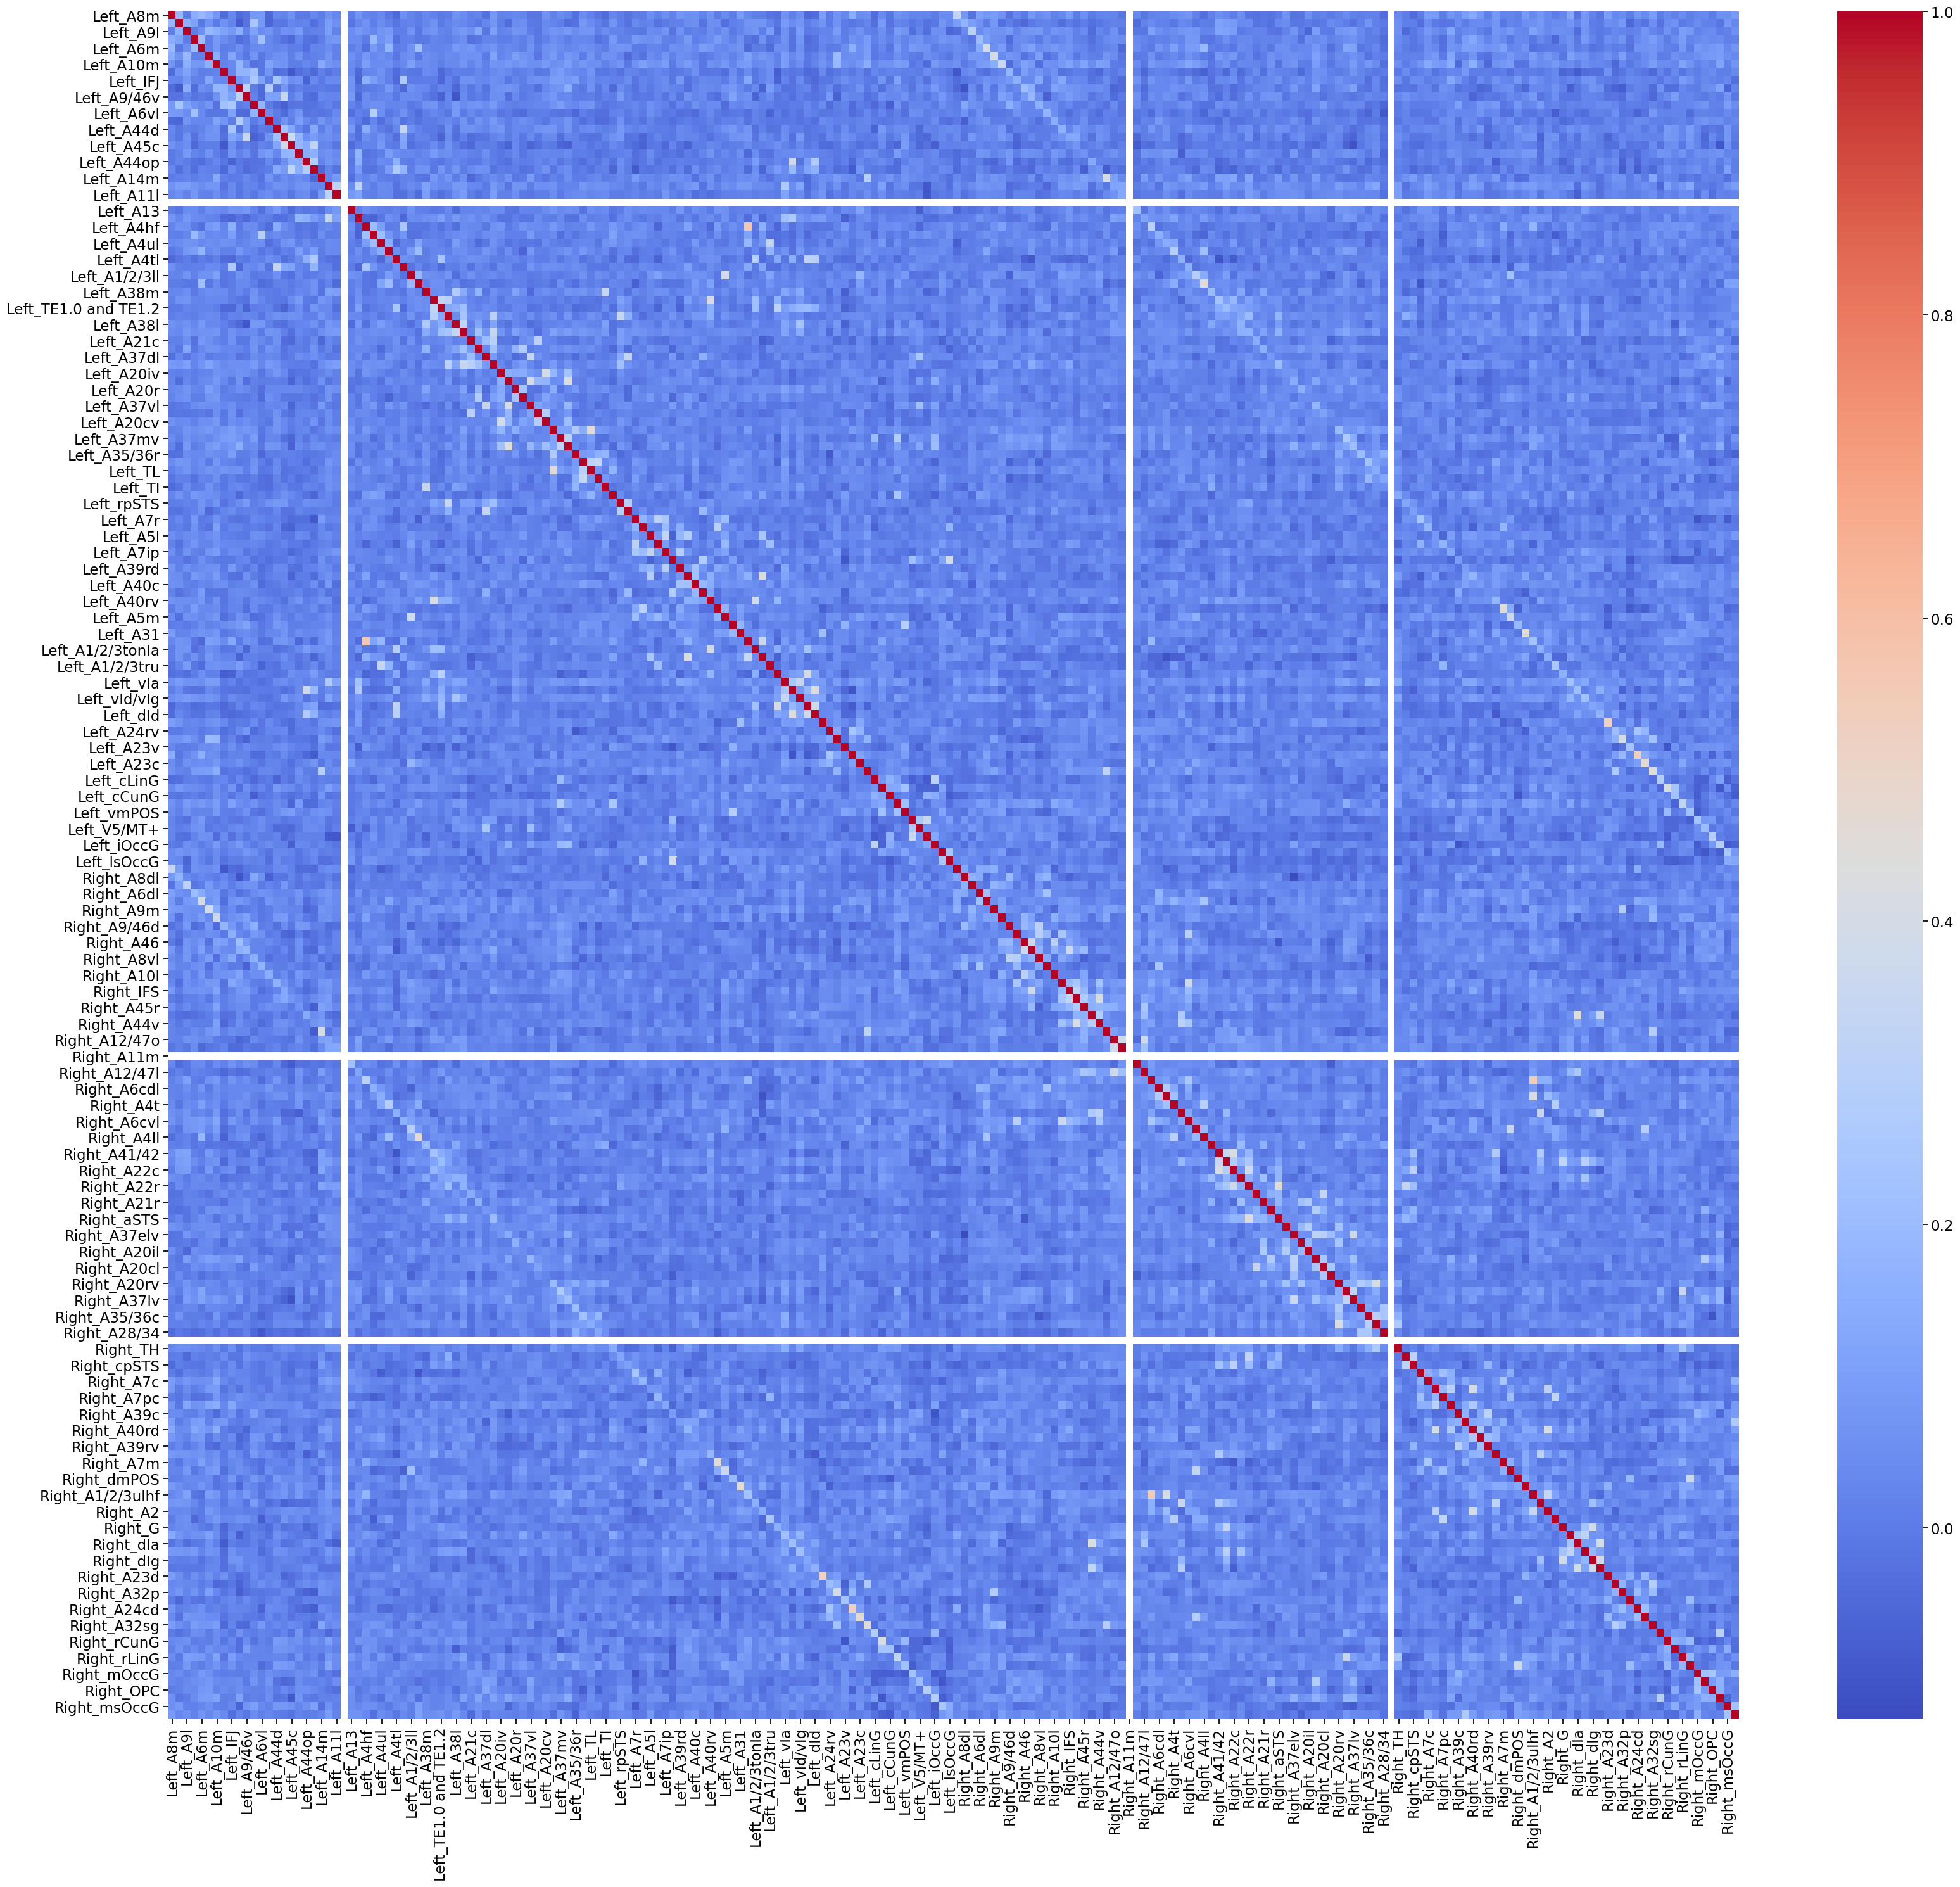

In [8]:
# Visualize entire matrix in its raw form
plt.figure(figsize=figsize)
ax = sns.heatmap(matDF, cmap=pallete, annot=False, linewidths=linewidth)
labelsx = [value.get_text() for value in list(ax.get_xticklabels())]
labelsy = [value.get_text() for value in list(ax.get_yticklabels())]
ax.set_yticklabels(DFnames.iloc[labelsy][0], rotation=0)
ax.set_xticklabels(DFnames.iloc[labelsx][0], rotation=90)
ax.set_xlim(0, len(matDF))
ax.set_ylim(len(matDF), 0)

##### As mentioned above, some regions (usually orbitofrontal - as we can see also in this matrix) might have to be removed do to a lack of signal. One can see these regions here as totally white columns or rows. Thus, it is necessary to remove them.

In [9]:
# Dropping regions with NaN. Be careful to maintain the original indices, 
# this allows the matching with the correct brain areas names
DFdropped = matDF.dropna(axis=1, how='all').dropna(axis=0,how='all').copy()

# Checking if there are NaNs, infs, zeros.
print('Matrix has Infs: ' + str(np.isinf(DFdropped.values).any()))
print('Matrix has NaNs: ' + str(np.isnan(DFdropped.values).any()))
print('Matrix has Zeros: ' + str((DFdropped.values==0).any()))

Matrix has Infs: False
Matrix has NaNs: False
Matrix has Zeros: False


In [10]:
# Finding where the NaNs, infs, zeros, are.
print('NaNs can be found at: \n' + str(np.argwhere(np.isnan(DFdropped.values))))
print('\n Infs can be found at: \n' + str(np.argwhere(np.isinf(DFdropped.values))))
print('\n Zeros can be found at: \n' + str(np.argwhere(DFdropped.values==0)))

NaNs can be found at: 
[]

 Infs can be found at: 
[]

 Zeros can be found at: 
[]


(207.0, 0.0)

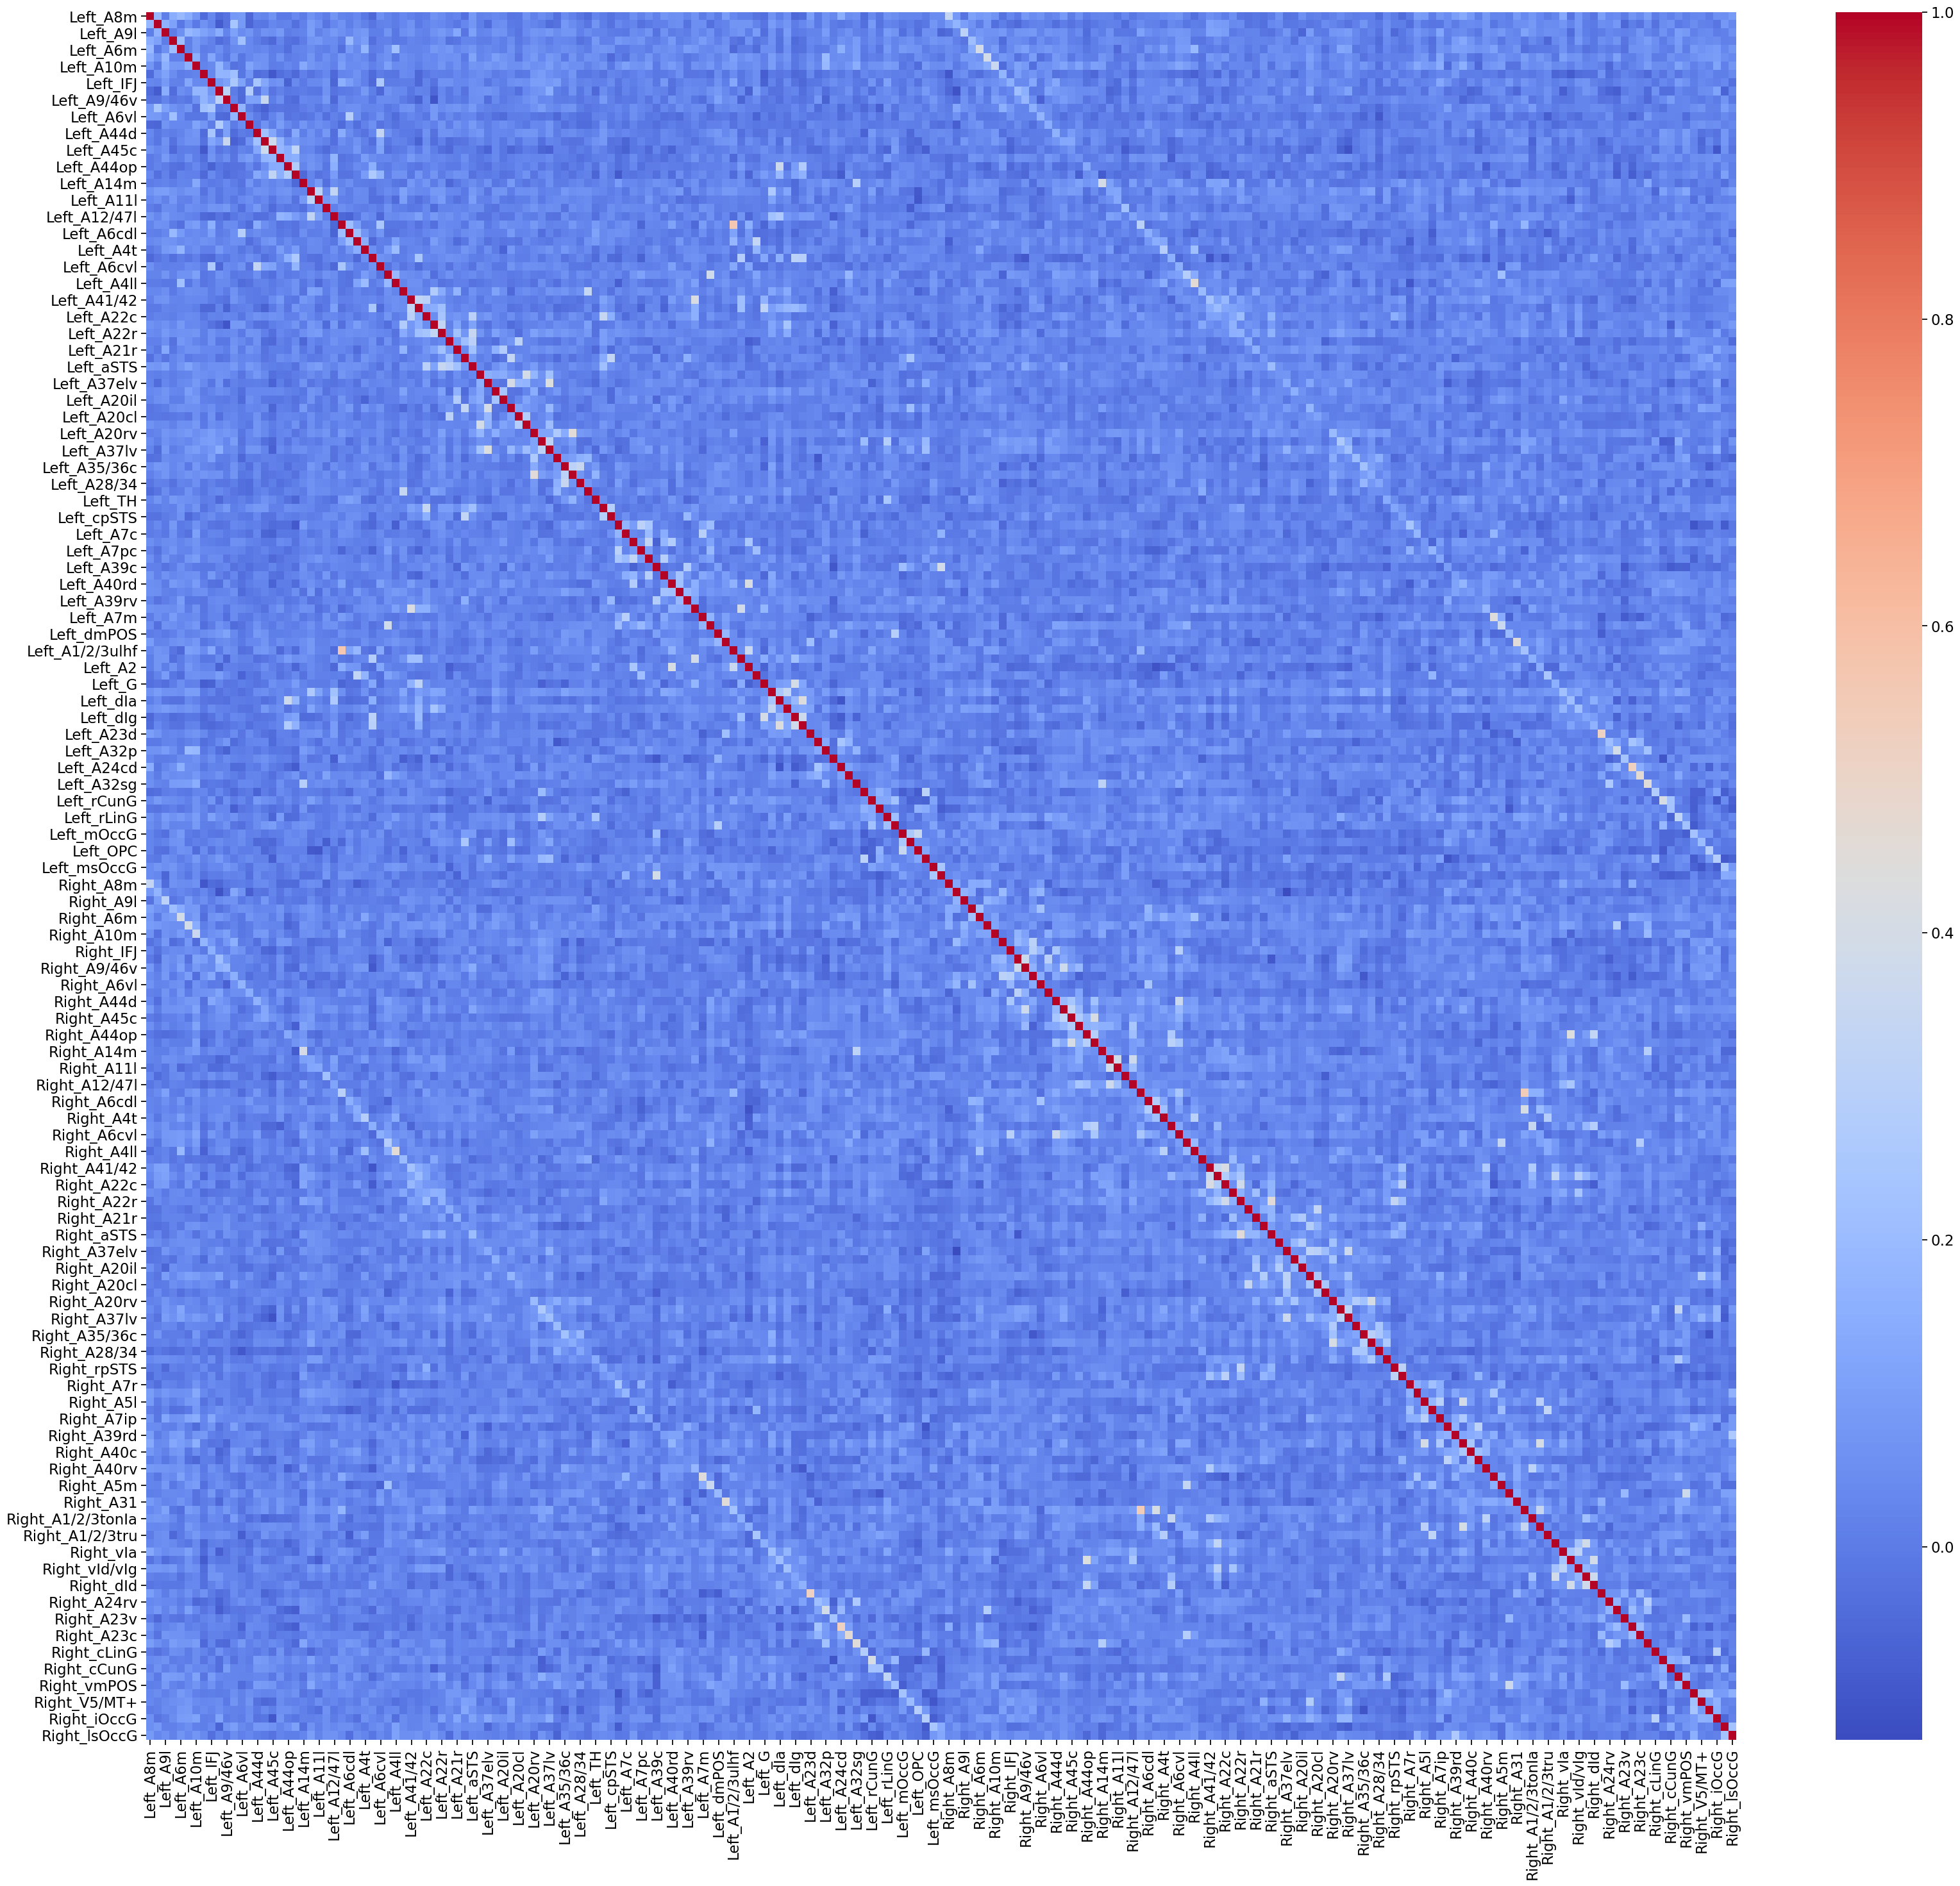

In [11]:
# Plotting new heatmap
plt.figure(figsize=figsize)

ax = sns.heatmap(DFdropped, cmap=pallete, annot=False, linewidths=linewidth)
labelsx = [value.get_text() for value in list(ax.get_xticklabels())]
labelsy = [value.get_text() for value in list(ax.get_yticklabels())]
ax.set_yticklabels(DFnames.iloc[labelsy][0], rotation=0)
ax.set_xticklabels(DFnames.iloc[labelsx][0], rotation=90)
ax.set_xlim(0, len(DFdropped))
ax.set_ylim(len(DFdropped), 0)

Now, one does not see these blank spaces anymore. One can also check how the matrice will not have NaNs anymore. 
As discussed above, it is possible to see 3 clear diagonals in the matrix. 


##### Now let's plot the connectivity distribution plots.
The distribution of connectivity easily shows whether there are outliers in connectivity values in your matrix, and whether the overall distribution fits with what we expect of fMRI data (i.e. a right-skewed distribution).

[Text(0, 0.5, 'Density Frequency'), Text(0.5, 0, 'Correlation Values')]

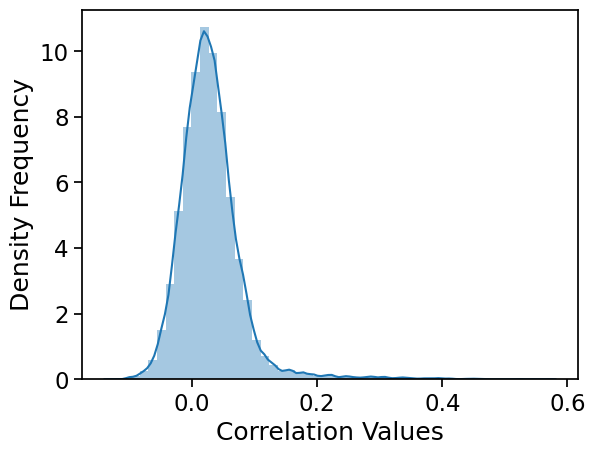

In [12]:
# Distribution of raw weights
np.fill_diagonal(DFdropped.values, np.nan) # Send to NaN to remove outliers (i.e. diagonal values)
rawdist = sns.distplot(DFdropped.values.flatten(), kde=True)
rawdist.set(xlabel='Correlation Values', ylabel = 'Density Frequency')

##### Now let's have a look at the DMN

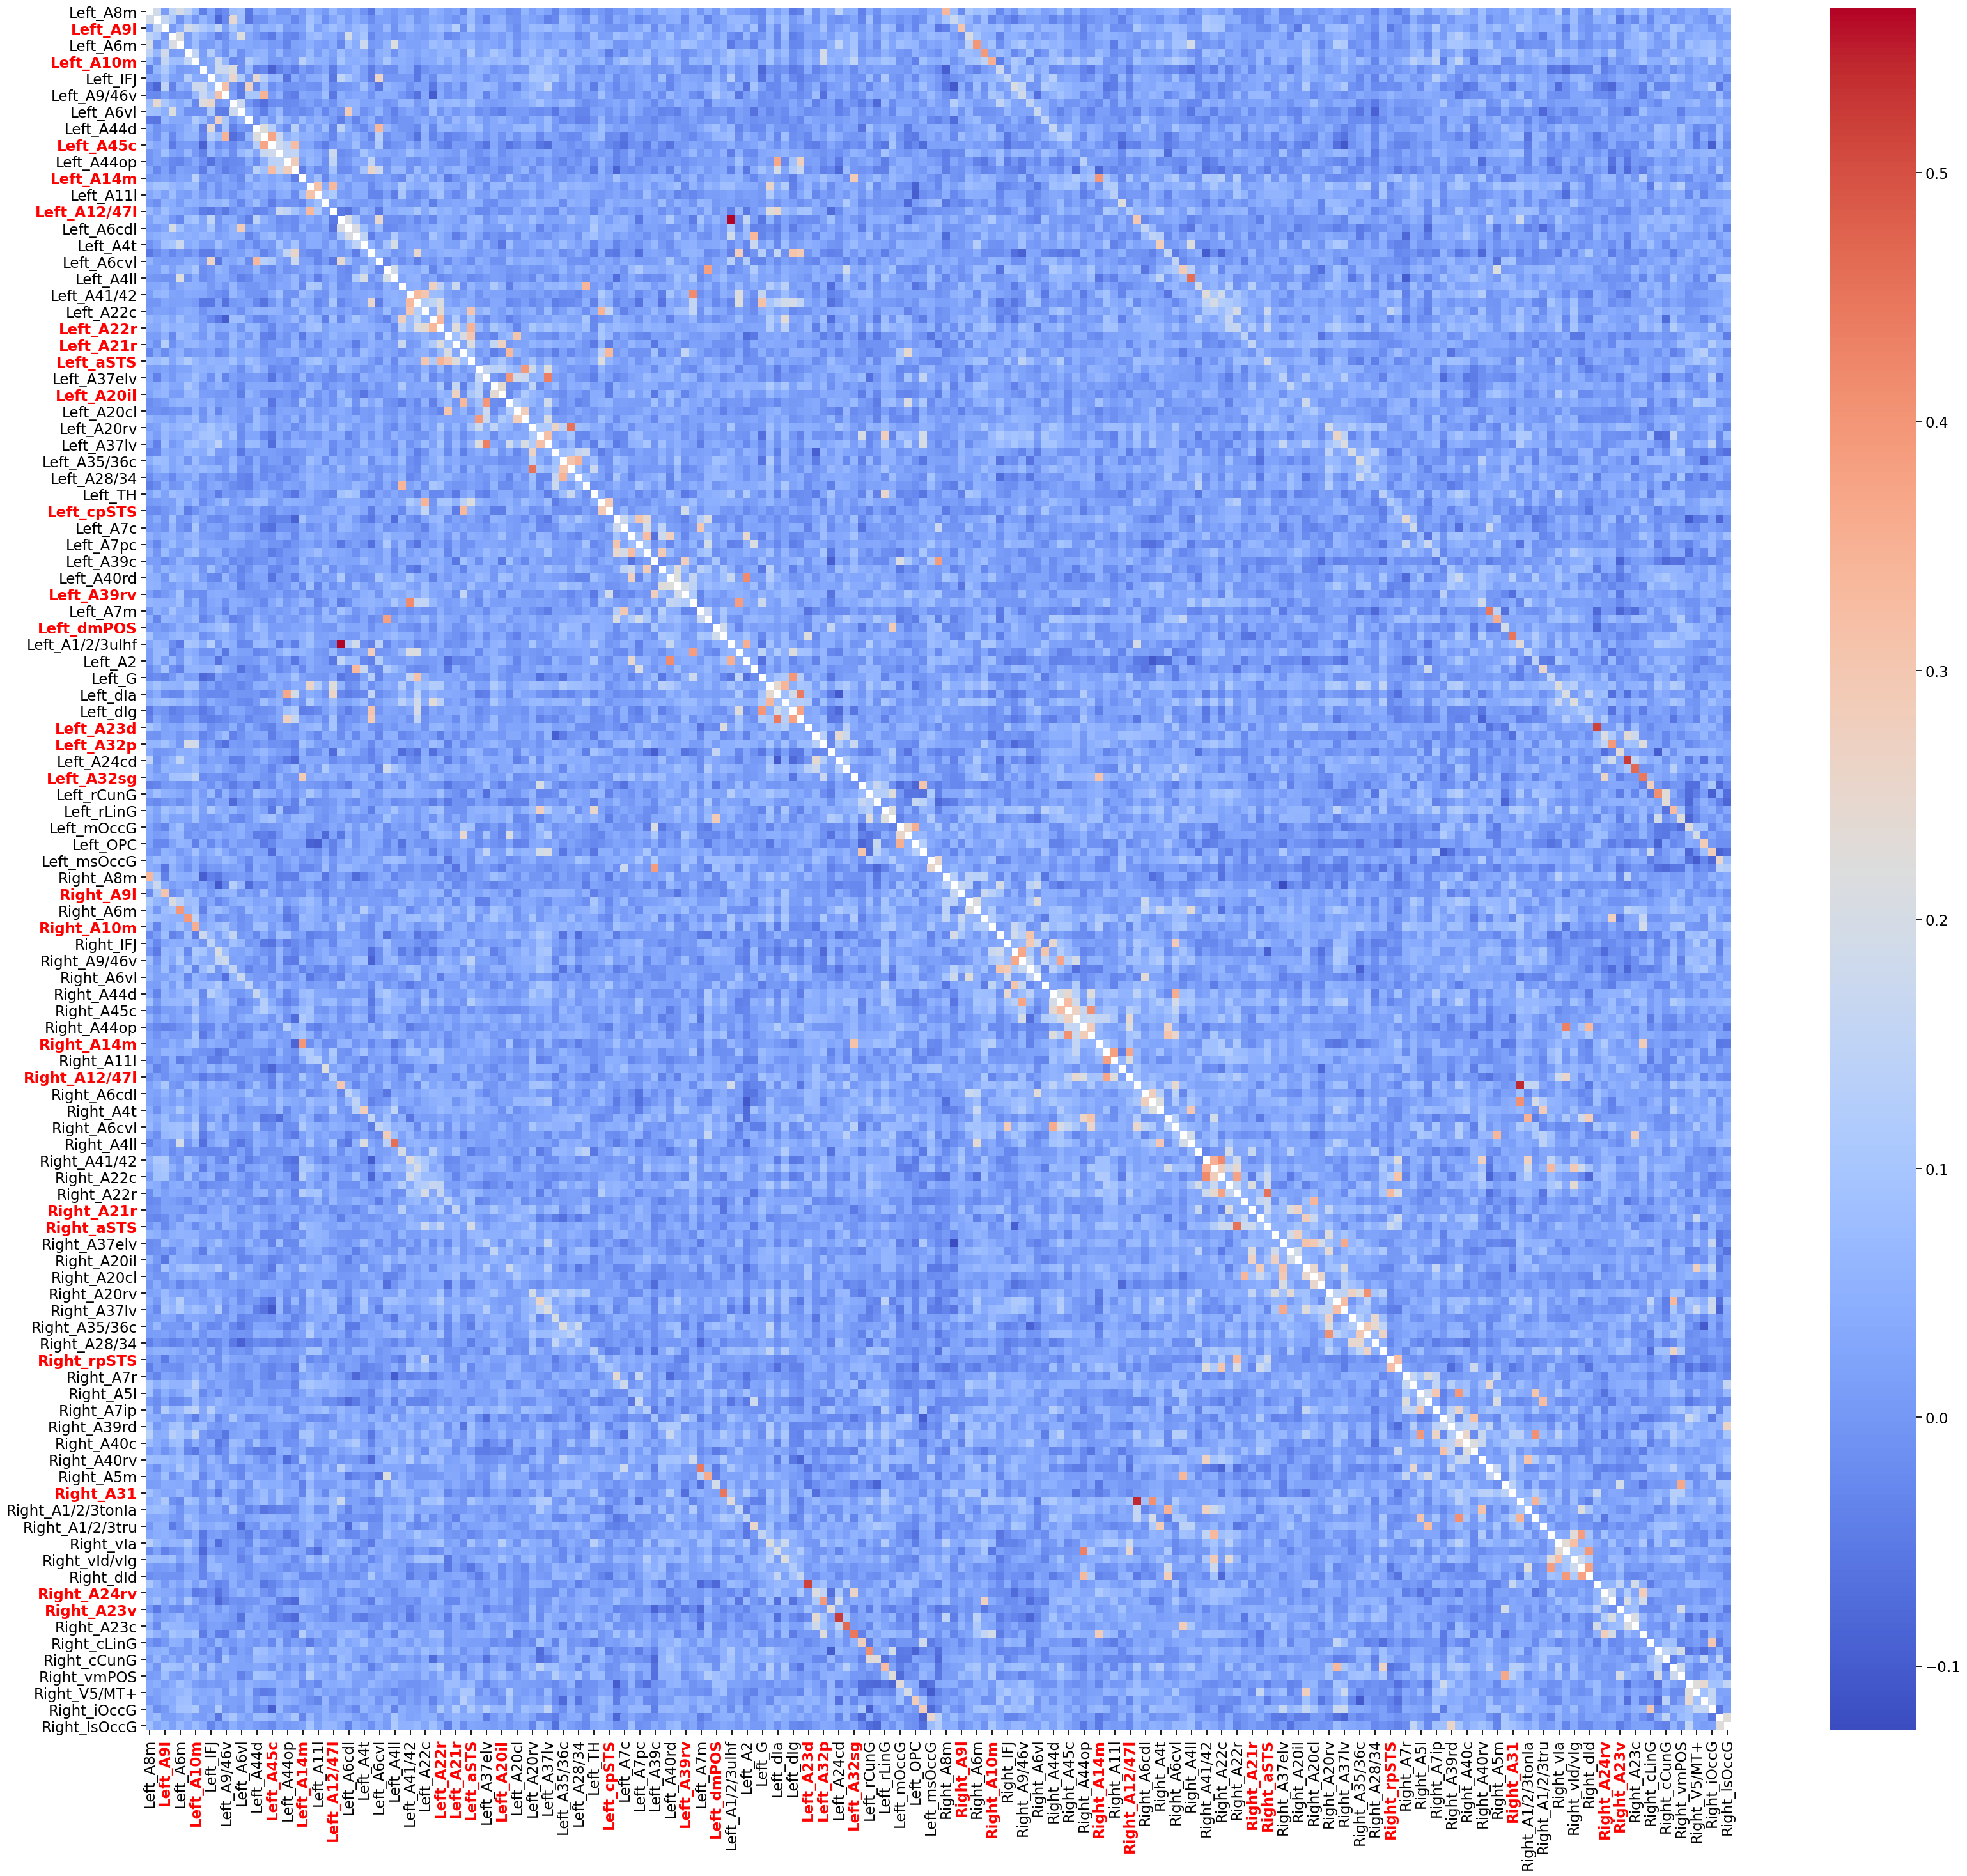

In [13]:
# Plotting with DMN regions in red
plt.figure(figsize=figsize)
ax = sns.heatmap(DFdropped, cmap=pallete, annot=False, linewidths=linewidth)
labelsx = [value.get_text() for value in list(ax.get_xticklabels())]
labelsy = [value.get_text() for value in list(ax.get_yticklabels())]
ax.set_yticklabels(DFnames.iloc[labelsy][0], rotation=0)
ax.set_xticklabels(DFnames.iloc[labelsx][0], rotation=90)
ax.set_xlim(0, len(DFdropped))
ax.set_ylim(len(DFdropped), 0)

dmn = np.where(regs==7)[0]
dmnNAMES = DFnames.iloc[dmn]
dmnNAMES = list(dmnNAMES.iloc[:,0])

for laby,labx in zip(ax.get_yticklabels(), ax.get_xticklabels()):
    texty = laby.get_text()
    textx = labx.get_text()
    if texty in dmnNAMES:
        laby.set_weight('bold')
        laby.set_color('red')
    if textx in dmnNAMES:
        labx.set_weight('bold')
        labx.set_color('red')

** The regions in red belong to the DMN.
*** Not having 1 in the diagonal might allow us to visualize better lower connectivity values. 

Now let's plot only the DMN regions:

(46.0, 0.0)

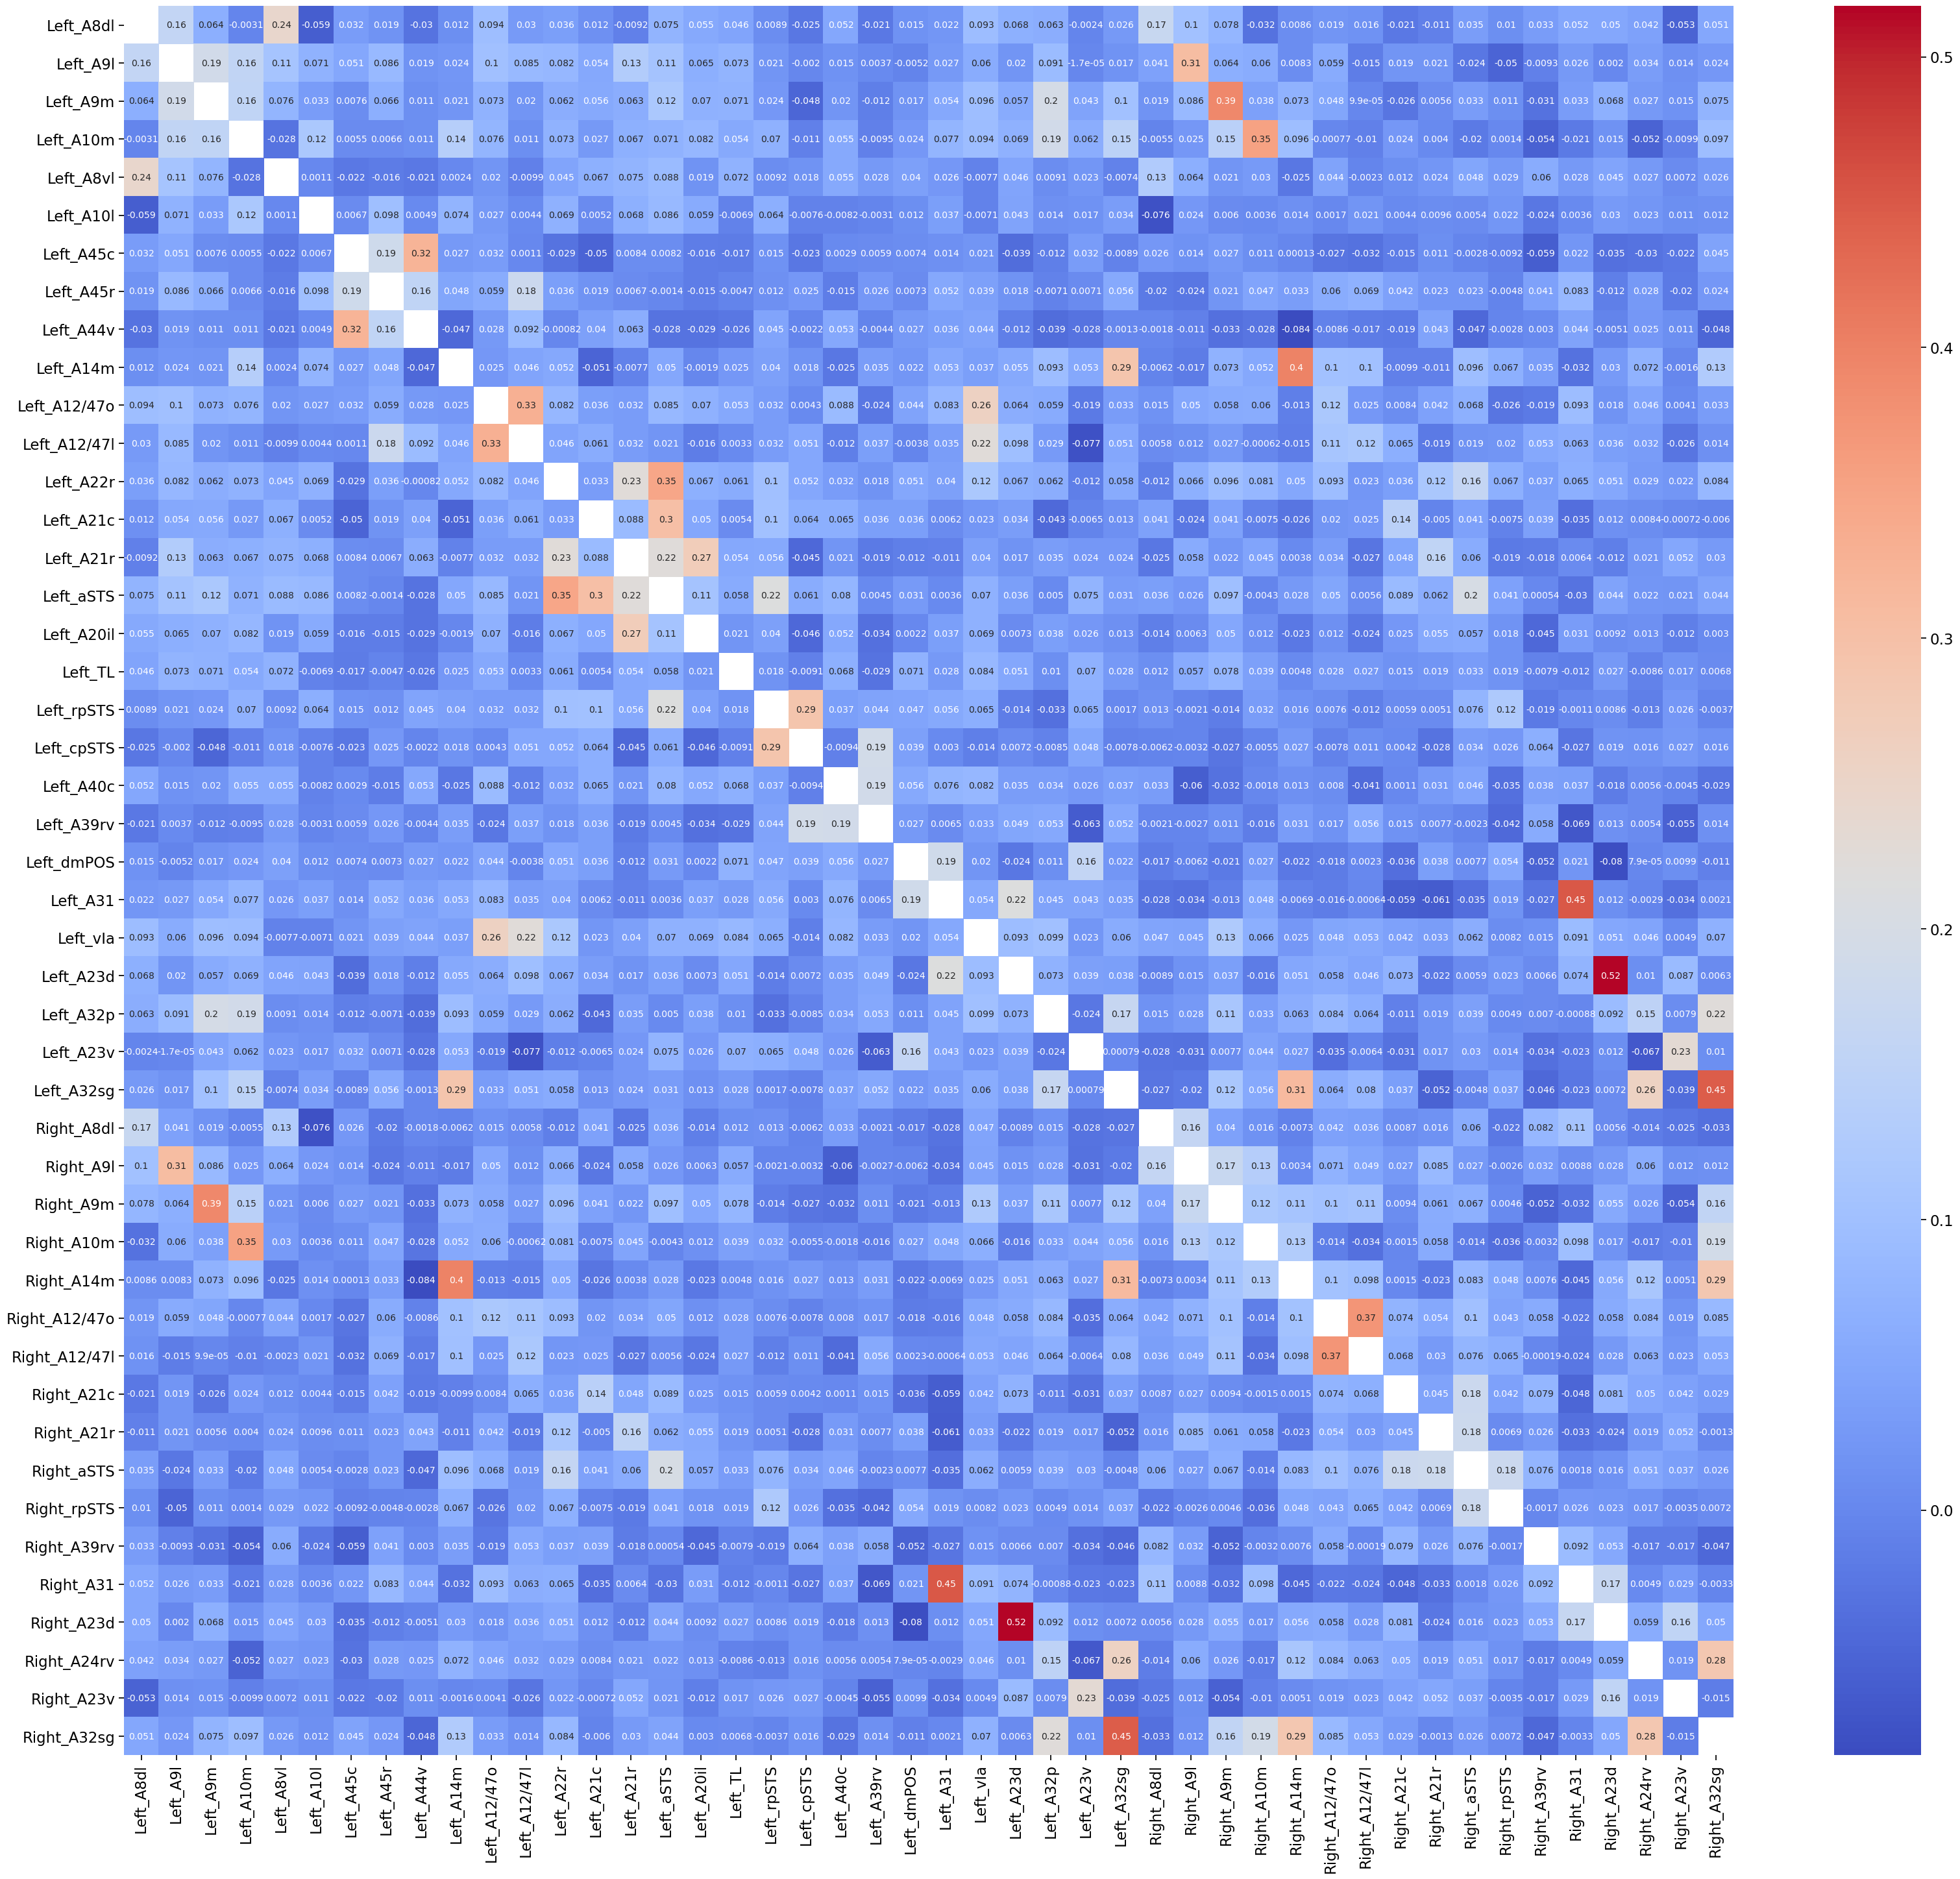

In [14]:
#Checking DMN using intersection
is_dmn  = sorted(list((set(dmn).intersection(DFdropped.columns))))
is_dmn = np.array(is_dmn) # Update DMN list to fit columns from rescaled matrix

dfDMN = DFdropped.filter(is_dmn, axis=0).filter(is_dmn, axis=1).copy()
   
plt.figure(figsize=figsize)
ax = sns.heatmap(dfDMN, cmap=pallete, annot=True, linewidths=linewidth, annot_kws={'size':size})
labelsx = [value.get_text() for value in list(ax.get_xticklabels())]
labelsy = [value.get_text() for value in list(ax.get_yticklabels())]
ax.set_yticklabels(pd.DataFrame(names).iloc[labelsy][0], rotation=0)
ax.set_xticklabels(pd.DataFrame(names).iloc[labelsx][0], rotation=90)
ax.set_xlim(0, len(dfDMN))
ax.set_ylim(len(dfDMN), 0)

An area that is usually evaluated to check for DMN connectivity is the precuneus (PrecR or L), and here we can indeed see a strong connection between them. Other than, that the whole diagonal that includes these DMN areas show, overall, strong connectivity. 

##### It is common practice to work with normalized matrices to overcome variability between scans, so now we will do the same as above, but now applying the normalization function.

In [15]:
def normalize(matrix): # Absolutize > Zscore > Rescale 
    """
    This function is supposed to normalize the matrices by first absolutizing it abs();
    Another important step is that we need to send the diagonal to NaN to not skew the mean/std.
    Then we compute a Z-score based on the matrix's mean and std. Taking into consideration that NaNs are present, we will use
    np.nanmean() and np.nanstd(). 
    Finally I rescale the matrix between 0 and 1 according to https://stats.stackexchange.com/questions/70801/how-to-normalize-data-to-0-1-range
    
    Arguments:
        matrix = numpy matrix
        
    Output: 
        zscored matrix & rescaled matrix
    """
    
    matrixabs = abs(matrix)
    np.fill_diagonal(matrixabs, np.nan)
    zmatrix = (matrixabs - np.nanmean(matrixabs))/np.nanstd(matrixabs)
    rescaled = (zmatrix - np.nanmin(zmatrix))/(np.nanmax(zmatrix)- np.nanmin(zmatrix))
    return zmatrix, rescaled

In [16]:
def checknorm(matrix, zmatrix, rescaled, pallete=pallete):
    """
    To double-check normalization function.
    
    Arguments:
        matrix = numpy matrix
        zmatrix = zscored version of matrix
        rescaled = rescaled version of matrix
        
    Output: 
        Plots of each matrix and its distribution.
    """
    fig,ax = plt.subplots(2,3, figsize=(55,30))
    sns.heatmap(matrix, cmap=pallete, ax=ax[0,0])
    sns.heatmap(zmatrix, cmap=pallete, ax=ax[0,1])
    sns.heatmap(rescaled, cmap=pallete, ax=ax[0,2])
    ax[0,0].set_ylim(len(matrix),0)
    ax[0,1].set_ylim(len(matrix),0)
    ax[0,2].set_ylim(len(matrix),0)
    sns.distplot(matrix.flatten(), kde=False, ax=ax[1,0])
    ax[1,0].set_xlabel('Raw Weights')
    sns.distplot(zmatrix.flatten(), kde=False, ax=ax[1,1])
    ax[1,1].set_xlabel('Z-Scored Weights')
    sns.distplot(rescaled.flatten(), kde=False, ax=ax[1,2])
    ax[1,2].set_xlabel('Normalized Weights')
    ax[0,0].set_title('Raw Matrix')
    ax[0,1].set_title('Z-Scored Matrix')
    ax[0,2].set_title('Rescaled Matrix')

###### Let's just observe in more detail the normalization process.

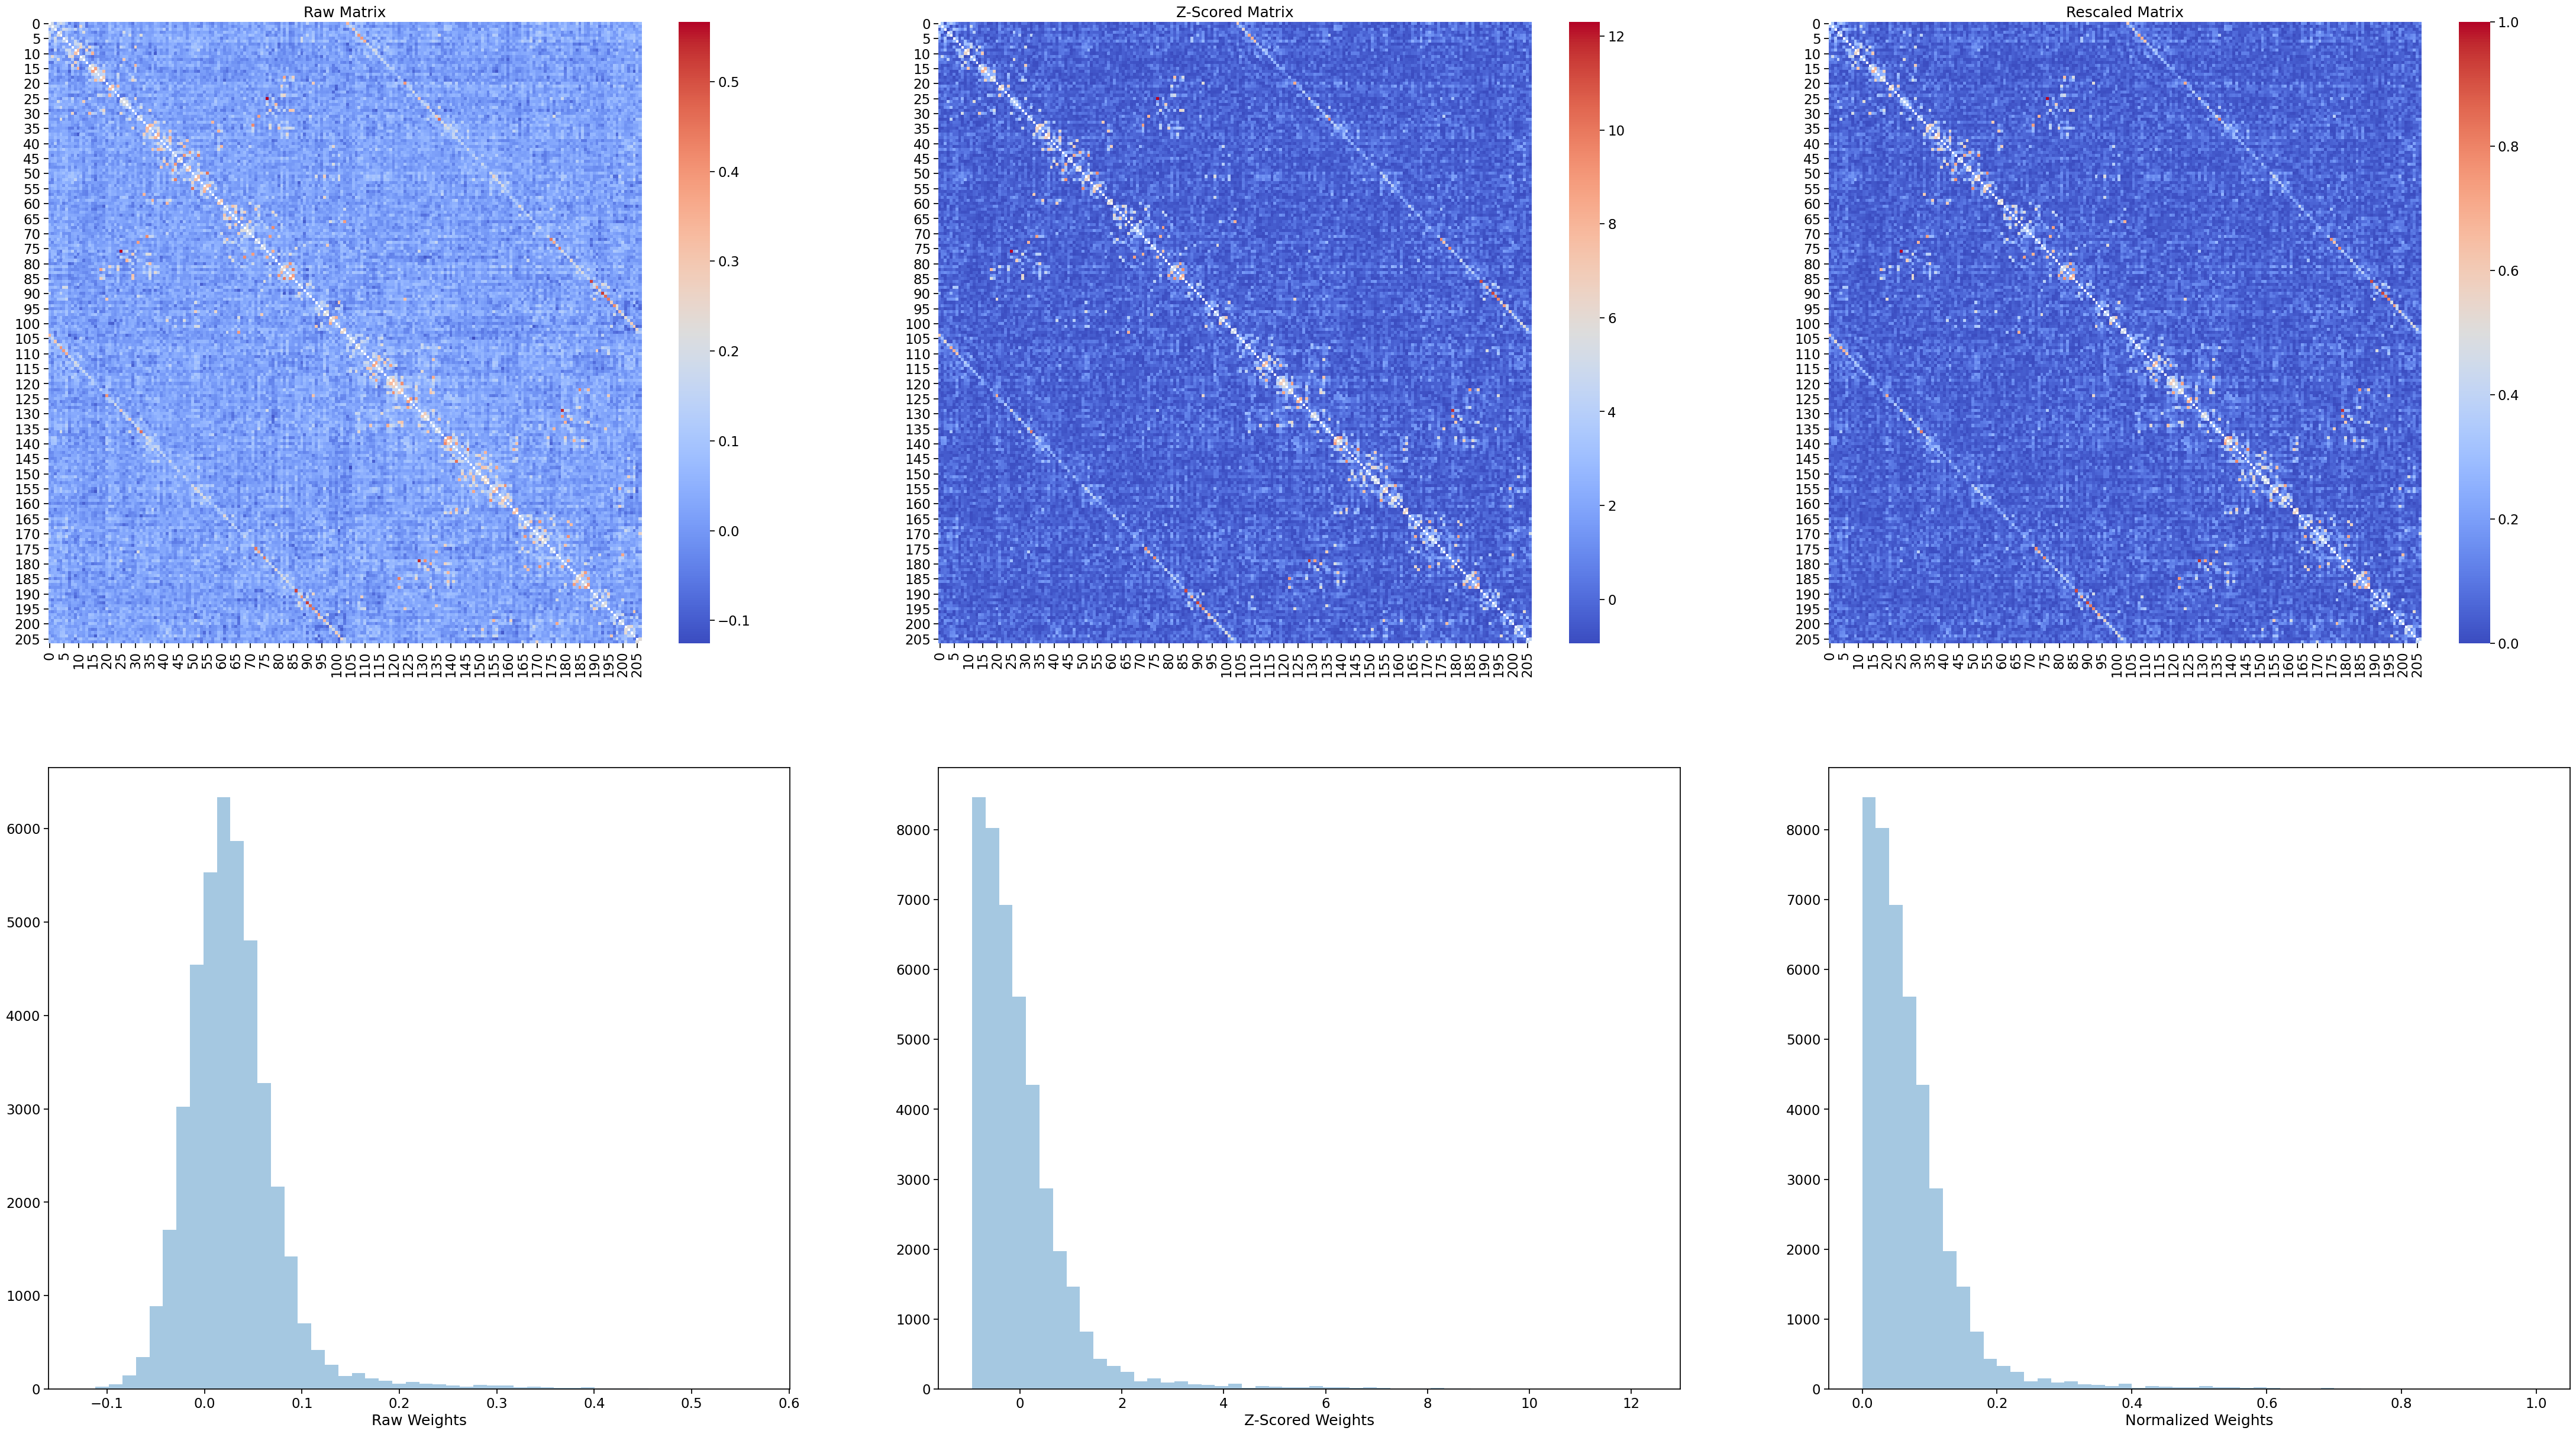

In [17]:
zmatrix, rescaled = normalize(DFdropped.values)
checknorm(DFdropped.values, zmatrix, rescaled)

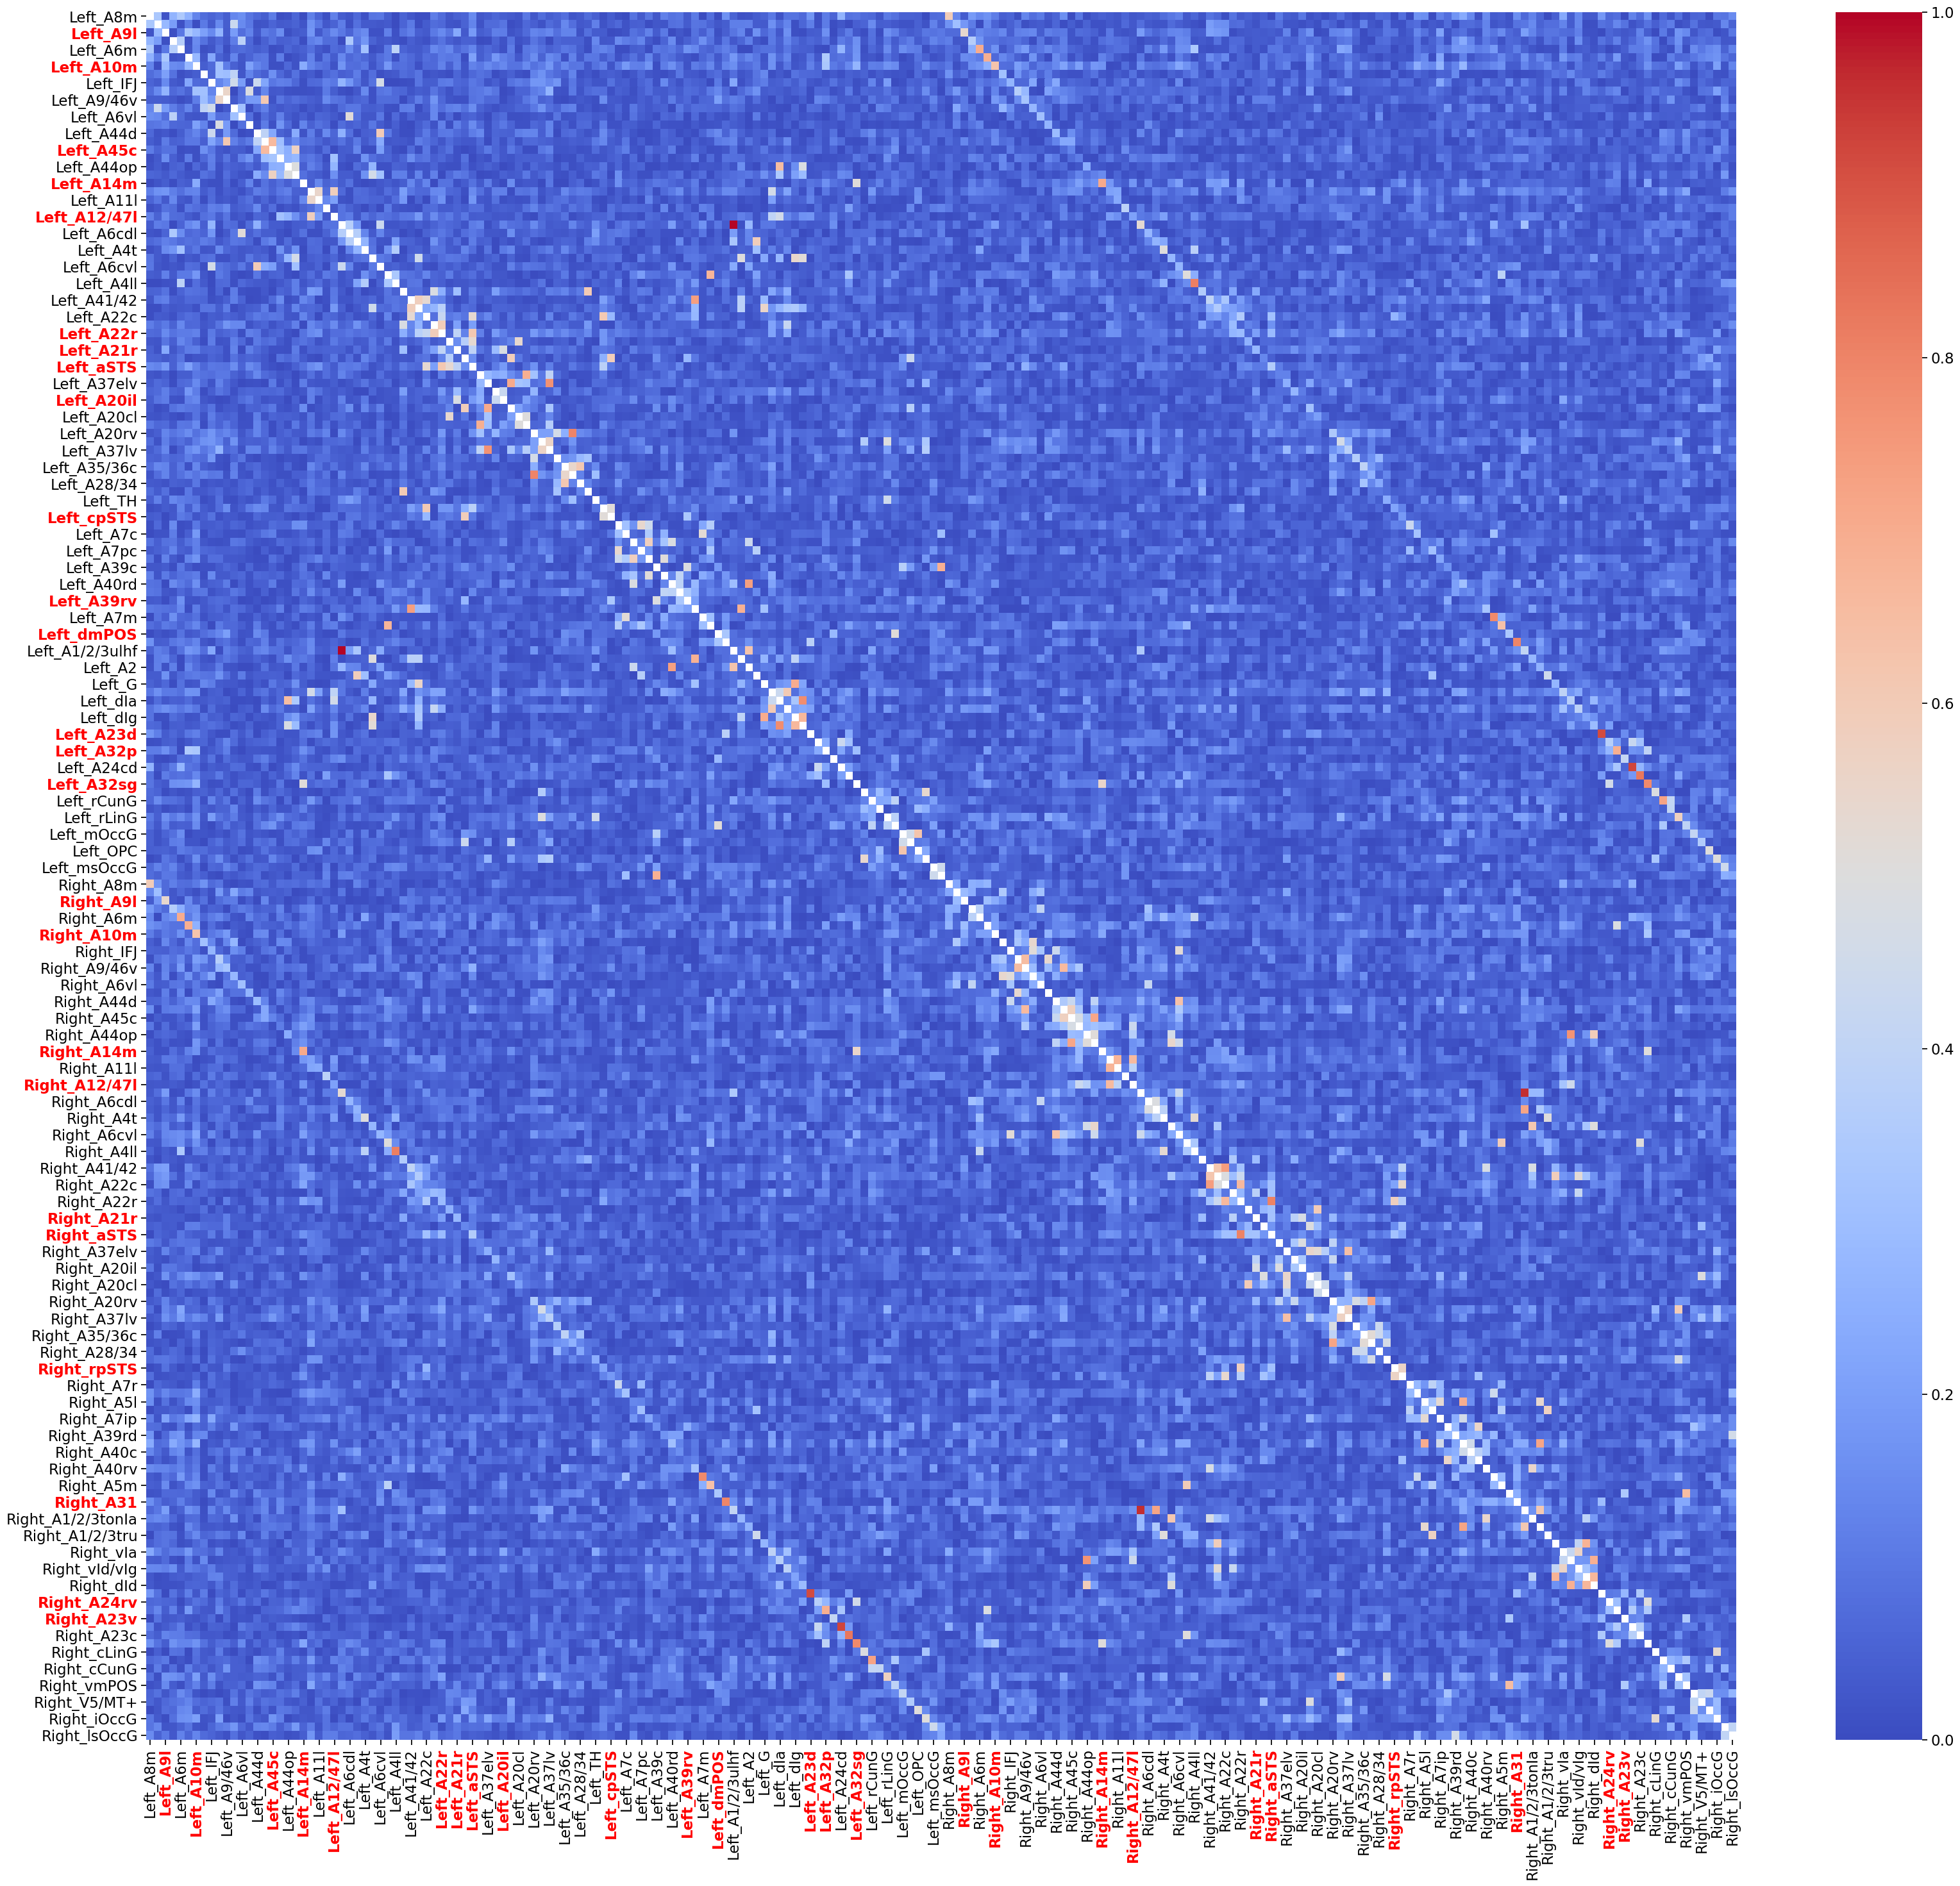

In [18]:
# A 'zoom' on the NORMALIZED matrix
DFnorm = pd.DataFrame(rescaled)
DFnorm.columns = DFdropped.columns # Returning the correct col/row numbers for proper filtering.
DFnorm.index = DFnorm.columns # Returning the correct col/row numbers for proper filtering.

plt.figure(figsize=figsize)
ax = sns.heatmap(DFnorm, cmap=pallete, annot=False, linewidths=linewidth)
labelsx = [value.get_text() for value in list(ax.get_xticklabels())]
labelsy = [value.get_text() for value in list(ax.get_yticklabels())]
ax.set_yticklabels(DFnames.iloc[labelsy][0], rotation=0)
ax.set_xticklabels(DFnames.iloc[labelsx][0], rotation=90)
ax.set_xlim(0, len(DFnorm))
ax.set_ylim(len(DFnorm), 0)

for laby,labx in zip(ax.get_yticklabels(), ax.get_xticklabels()):
    texty = laby.get_text()
    textx = labx.get_text()
    if texty in dmnNAMES:
        laby.set_weight('bold')
        laby.set_color('red')
    if textx in dmnNAMES:
        labx.set_weight('bold')
        labx.set_color('red')

** Regions in red belong to the DMN

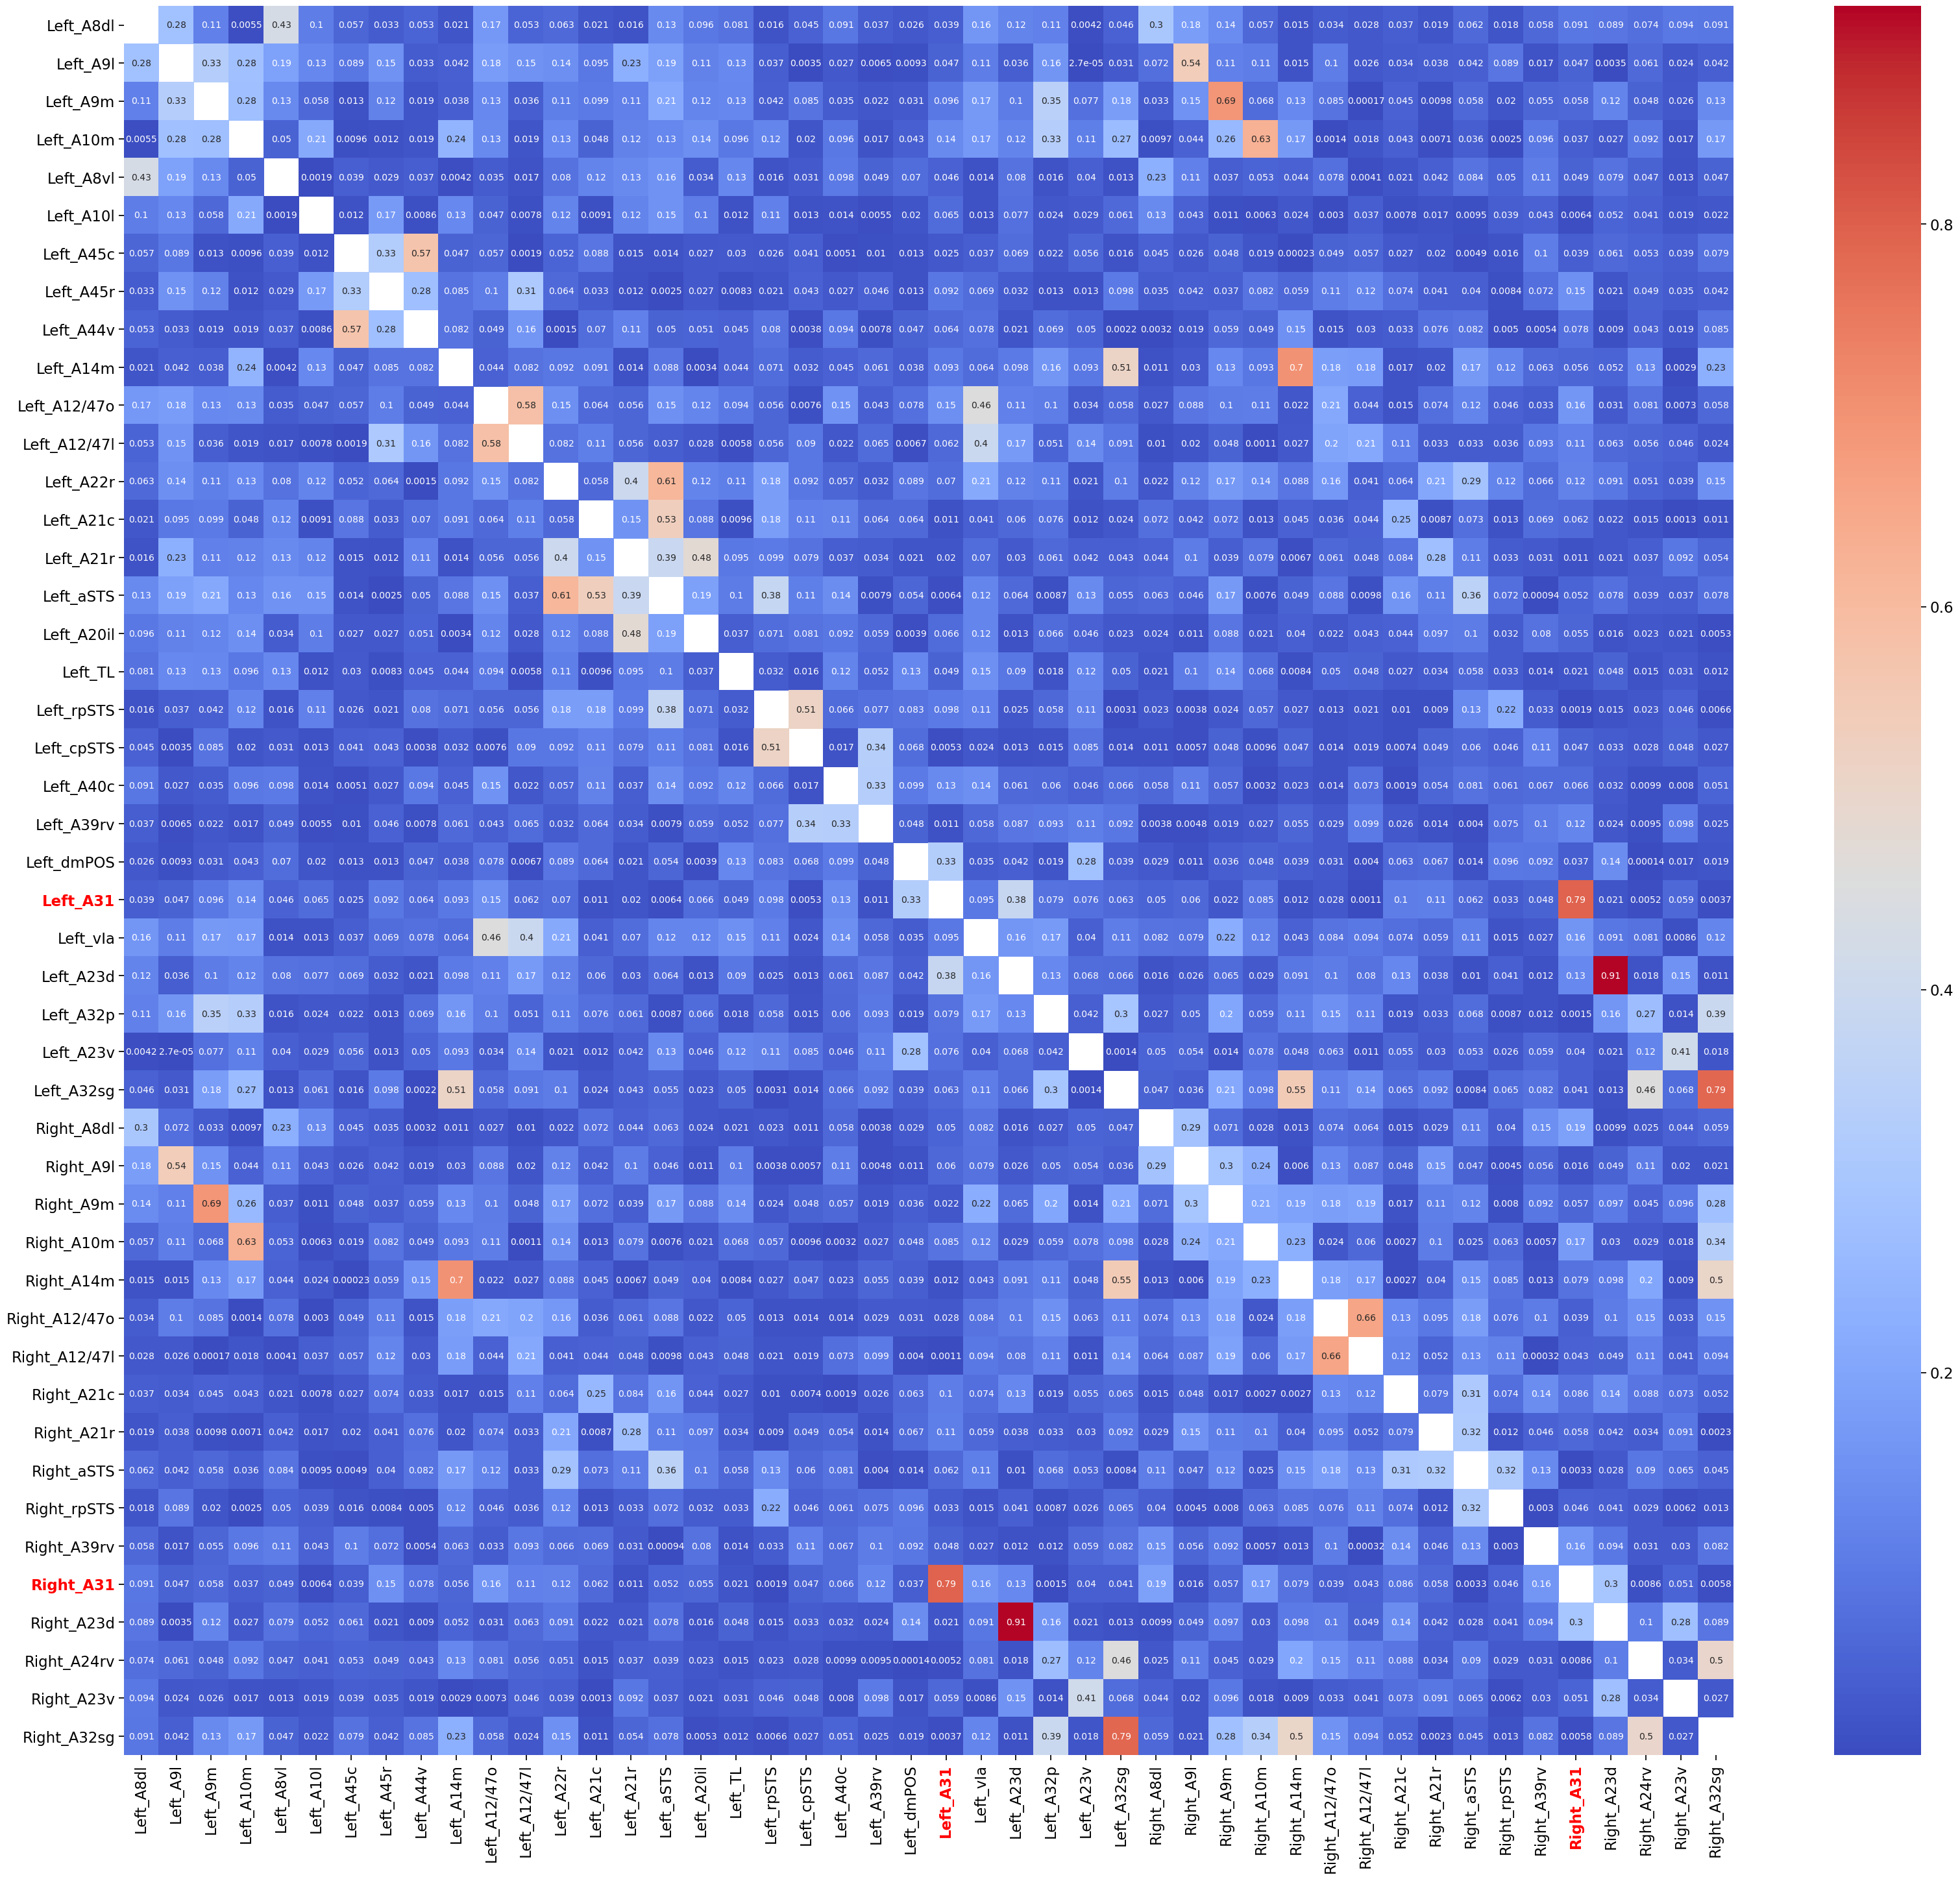

In [19]:
# Checking the DMN in NORMALIZED matrix
DFnormDMN = DFnorm.filter(is_dmn, axis=0).filter(is_dmn, axis=1).copy()
   
plt.figure(figsize=figsize)
ax = sns.heatmap(DFnormDMN, cmap=pallete, annot=True, linewidths=linewidth, annot_kws={'size':size})
labelsx = [value.get_text() for value in list(ax.get_xticklabels())]
labelsy = [value.get_text() for value in list(ax.get_yticklabels())]
ax.set_yticklabels(DFnames.iloc[labelsy][0], rotation=0)
ax.set_xticklabels(DFnames.iloc[labelsx][0], rotation=90)
ax.set_xlim(0, len(DFnormDMN))
ax.set_ylim(len(DFnormDMN), 0)


for laby,labx in zip(ax.get_yticklabels(), ax.get_xticklabels()):
    texty = laby.get_text()
    textx = labx.get_text()
    if texty in [prec_L_area, prec_R_area]:
        laby.set_weight('bold')
        laby.set_color('red')
    if textx in [prec_L_area, prec_R_area]:
        labx.set_weight('bold')
        labx.set_color('red')

Now let's evaluate the average connectivity of the Precuneus within and outside the DMN. 

In [20]:
DFfinal = DFnorm.copy()
DFfinal.columns = DFnames.iloc[DFfinal.columns][0]
DFfinal.index = DFfinal.columns
DFfinal.index.name = None

notDMN = np.where(regs!=7)[0]
notDMN = DFnames.loc[notDMN]

print('Average connectivity of the left Precuneus with the rest of the matrix: ' + str(np.nanmean(DFfinal.loc[prec_L_area].filter(notDMN[0]))))
print('Average connectivity of the left Precuneus within the DMN: ' + str(np.nanmean(DFfinal.loc[prec_L_area].filter(dmnNAMES))))
print('Average connectivity of the right Precuneus with the rest of the matrix: ' + str(np.nanmean(DFfinal.loc[prec_R_area].filter(notDMN[0]))))
print('Average connectivity of the right Precuneus within the DMN: ' + str(np.nanmean(DFfinal.loc[prec_R_area].filter(dmnNAMES))))                                                                    

Average connectivity of the left Precuneus with the rest of the matrix: 0.07158615911404213
Average connectivity of the left Precuneus within the DMN: 0.08667134755797089
Average connectivity of the right Precuneus with the rest of the matrix: 0.07438214348877553
Average connectivity of the right Precuneus within the DMN: 0.08785164616226937
